# Interbank Network Simulation (Refined)

Using the Furfine Algorithm, we calculate the effect of a random bank default in the setting of an Erdos-Renyi network. This is done as follows:

1. Create a bank object with a fixed balance sheet. 
2. Initialise a network where nodes are banks and edges are interbank loans.
   - A network is connected to another network if a number chosen at random is smaller than some probability p.
3. Randomly default one of the banks in the network by setting their assets to zero. 
4. Recalculate the total assets of each bank connected to the defaulted bank.
   - To do this, subtract the defaulted bank's interbank liability from its neighbouring banks' assets.
5. If for the neighbouring banks' assets are now less than zero, mark this as another default and repeat step 3 onwards modelling the defaulting bank as this bank.


## Generate a Random Financial Network

In [1]:
EXTERNAL_ASSETS = 0.3

In [8]:
class Bank(object):
    def __init__(self, bank_id, interbank_assets=0.2, liabilities=0.96, default=False):
        self.bank_id = bank_id
        self.interbank_assets = interbank_assets
        self.liabilities = liabilities
        self.default = default
        self.bank_connected = []
        global EXTERNAL_ASSETS
        self.total_assets = self.interbank_assets + EXTERNAL_ASSETS
        self.edges = [] # Elements of edges: (the bank itself, the bank it borrows money from, the amount of liabilities)
        
    # For NetworkX to label the bank based on ID.
    def __str__(self):
        return str(self.bank_id)
    
    # This function is called when the bank connected to 'self' defaults, transmitting its loss to the asset.
    def update_total_assets(self, loss):
        self.total_assets = self.total_assets - loss
        if(self.total_assets < 0):
            self.default_bank()
        
    # This function is called every time 'self' borrows money from a new bank.  
    def update_connection(self, bank):
        self.bank_connected.append(bank)
    
    # This function is called when the bank is set to default.
    def default_bank(self):
        self.default = True
        if(self.total_assets >= 0.0):
            self.total_assets = 0.0
        for bank in self.bank_connected:
            bank.update_total_assets(self.current_liabilities())
    
    # Erdos Renyi, where the link weights are uniform. 
    def current_liabilities(self):
        k = len(self.bank_connected)
        return self.liabilities/k
    
    # This function is called when the bank finishes borrowing from other banks, and it can list out all edges (from itself to other banks) with associated weights.
    def compile_connection(self):
        for bank in self.bank_connected:
            self.edges.append((self.bank_id, bank.bank_id, self.current_liabilities()))

## Generate the Graph

In [47]:
class Graph(object):
    def __init__(self, bank_number=5, borrow_probability=0.25):
        self.bank_number = bank_number
        self.borrow_probability = borrow_probability
        self.bank_list = []
    
    # Generate random banks and random connections between banks.
    def generate_bank(self):
        for i in range(self.bank_number):
            newBank = Bank(bank_id=i)
            self.bank_list.append(newBank)
        
        potential_lender = self.bank_list.copy()
        
        for bank in self.bank_list:
            for lender in potential_lender:
                import random
                tendency = random.uniform(0, 1) # Generate random number. The lower, the higher chance of a connection.
                if(bank!=lender and tendency < self.borrow_probability):
                    bank.update_connection(lender)
            bank.compile_connection()

    def draw_graph(self):
        self.generate_bank()
        import pygraphviz as pgv
        G=pgv.AGraph(strict=False,directed=True)
        G.add_nodes_from(self.bank_list)
        G.edge_attr['penwidth']=1.0
        G.edge_attr['fontcolor']='red'
        G.edge_attr['len']= 0.3 * self.bank_number
        for bank in self.bank_list:
            for edge in bank.edges:
                G.add_edge(edge[0], edge[1], label=round(edge[2],2))        
        
        G.layout()
        G.draw('network.png') 
        
    def print_banks_status(self):
        for bank in self.bank_list:
            defaultStatus = 'Default' if bank.default else 'Active'
            print('Bank ', bank.bank_id, ' : {0:.3f}'.format(round(bank.total_assets,3)), ' ' , defaultStatus)
            
    def random_default_bank(self):
        import random
        random_bank = random.choice(self.bank_list)
        random_bank.default_bank()
        print("The bank chosen to default is Bank" , random_bank.bank_id)

## Initialise and Display Graph

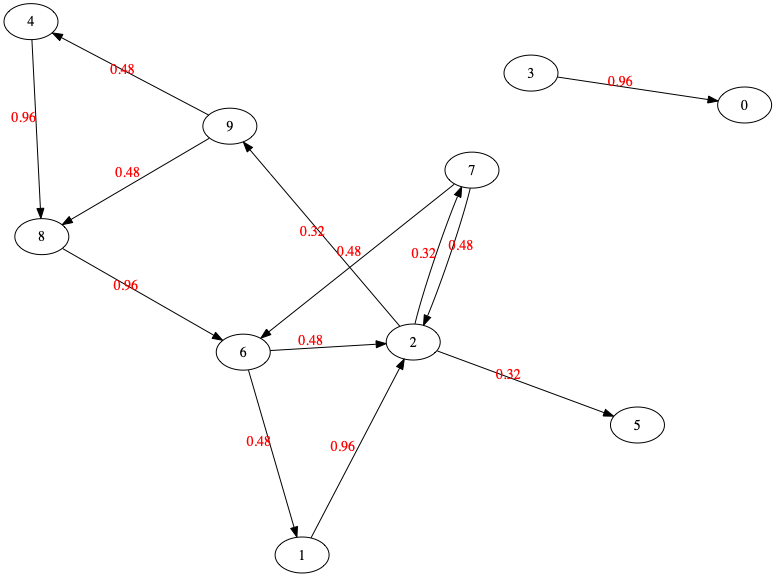

In [56]:
graph = Graph(bank_number=10)
graph.draw_graph()
from IPython.display import Image
Image('network.png')

In [57]:
graph.print_banks_status()

Bank  0  : 0.500   Active
Bank  1  : 0.500   Active
Bank  2  : 0.500   Active
Bank  3  : 0.500   Active
Bank  4  : 0.500   Active
Bank  5  : 0.500   Active
Bank  6  : 0.500   Active
Bank  7  : 0.500   Active
Bank  8  : 0.500   Active
Bank  9  : 0.500   Active


## Randomly Default a Bank

In [58]:
graph.random_default_bank()

The bank chosen to default is Bank 8


In [59]:
graph.print_banks_status()

Bank  0  : 0.500   Active
Bank  1  : 0.020   Active
Bank  2  : 0.020   Active
Bank  3  : 0.500   Active
Bank  4  : 0.500   Active
Bank  5  : 0.500   Active
Bank  6  : -0.460   Default
Bank  7  : 0.500   Active
Bank  8  : 0.000   Default
Bank  9  : 0.500   Active


### Todo:
1. Functions for calculating (a) average degree of a graph and (b) probability of contagion
2. Add graph of average degree (x-axis) against probability of contagion (y-axis).